# Neuron Model Tutorial

## Objectives:
- Build the **Leaky Integrate and Fire neuron model** by abstracting Hodgkin Huxley equations
- Describe a neuron model's **Input/Output Relationship**
    - Use **noise** in current input
    - **Frequency** as a function of current input
    - Quantify **regularity of spiking** as a function of current input noise

## Install Packages

In [1]:
!pip install ./dependencies/numpy/*

Processing ./dependencies/numpy/numpy-1.24.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
numpy is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [2]:
!pip install ./dependencies/matplotlib/*

Processing ./dependencies/matplotlib/Pillow-9.5.0-cp311-cp311-manylinux_2_28_x86_64.whl
Processing ./dependencies/matplotlib/contourpy-1.0.7-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing ./dependencies/matplotlib/cycler-0.11.0-py3-none-any.whl
Processing ./dependencies/matplotlib/fonttools-4.39.3-py3-none-any.whl
Processing ./dependencies/matplotlib/kiwisolver-1.4.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing ./dependencies/matplotlib/matplotlib-3.7.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing ./dependencies/matplotlib/numpy-1.24.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing ./dependencies/matplotlib/packaging-23.0-py3-none-any.whl
Processing ./dependencies/matplotlib/pyparsing-3.0.9-py3-none-any.whl
Processing ./dependencies/matplotlib/python_dateutil-2.8.2-py2.py3-none-any.whl
Processing ./dependencies/matplotlib/six-1.16.0-py2.py3-none-any.whl
Pillow is already installed with the s

## Import Packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## Set up Helper Functions

In [4]:
def my_GWN(pars, mu, sig, myseed=False):
    """
    Function that generates Gaussian white noise input

    Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    myseed     : random seed. int or boolean
                 the same seed will give the same
                 random number sequence

    Returns:
    I          : Gaussian white noise input
    """

    # Retrieve simulation parameters
    dt, T = params['dt'], params['T']
    t = np.arange(0, T, dt)
    t_len = len(t)

    # Set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # Generate GWN
    # we divide here by 1000 to convert units to sec.
    I_gwn = mu + sig * np.random.randn(t_len) / np.sqrt(dt / 1000.)

    return I_gwn, t

## Section 1: A Return to the Hodgkin Huxley Equations

Biophysical modeling on neurons involves:
- knowing the input/output relationship you want to describe
- building the form your model is going to take
- testing to see if your model meets certain validity criteria when compared to real data (this is outside the scope of this tutorial)

![modeling](./images/1_modeling.png)

When modeling a neuron, or even a patch of neuronal membrane, it is important to remember that in most cases, we are providing an externally sourced **current input** and measuring a **voltage output**. These values determine the **input/output relationship.**

Hodgkin Huxley models are a widely accepted form of biophysical model, due in large part because the model was built to reproduce the input-output function of an action potential from a squid giant axon. Hodgkin and Huxley successfully crafted a model with the right parameters to create model output that matched the data output. This comparison demonstrated the **validity** of the model, and is a classic way to show one's model is "good".

One particularly nice property of Hodgkin Huxley equations are that their form ended up reflecting empirically-based objects in the biological system. See the most general form of it below:

$$ I_{ext} = I_{C_m} + I_L + I_{Na} + I_K $$

Where $I_{ext}$ is the externally sourced current, $I_{C_m}$ is the capacitative current, $I_L$ is the leak current, and, most notably, $I_{Na}$ and $I_K$ are the sodium and potassium currents. The conceptual leap Hodgkin and Huxley made in this model was to introduce terms that reflected the contribution of sodium and potassium currents, separately. These terms correspond to empirically-based properties, the voltage gated sodium and potassium channels, in neurons. These properties can be manipulated both in the model and in real life (using sodium or potassium channel blockers), which makes this particular model powerful.

## Section 2: Building a Leaky Integrate and Fire Model

In the explanation above, we see how the question of "What generates an action potential?" is answered well with the HH model. However, what if we wanted to ask a different question?

Neurons produce many action potentials over time. We could then ask:
- Given a current input, how often does a neuron spike?
- Given a current input, how regularly or irregularly does a neuron spike?

Using a HH model to answer these questions could be computationally expensive to simulate due to the complex dynamics for evaluating the contributions of $I_{Na}$ and $I_K$.

Asking different questions and computational feasibility are major reasons why one would try to build a new neuron model that is simpler and easier to compute.

### Section 2.1: Building a "proto"-LIF Model

What can we do to make the HH model simpler? As a requirement, we want to largely maintain the relevant properties of the input/output function we need to answer our questions.

Let's look at an input/output function of a neuron.

<div>
<img src="./images/2_AP_features.svg" width="400"/>
</div>

$I(t)$ corresponds to input current, $V(t)$ corresponds to output voltage.

If we are trying to investigate action potential spike timing, like with our questions above, then perhaps all we need to do is produce a model that can recreate when the spike occurs. 

Do we need to recreate the shape of the spike to do this? Probably not. All we need to know is how to recreate the features of the voltage trace that don't include making the spike shape.

Our new model thus only needs to have the following properties:
- Use input current to depolarize the membrane voltage until a threshold ($V_{th}$) is reached
- Hyperpolarize back to resting state ($V_{rest}$), restarting the process

We can do this by using the HH model as a starting point.

The $I_{Na}$ and $I_K$ terms are necessary for the the action potential shape after reaching $V_{th}$ and the hyperpolarization back to around resting state voltage potential at $V_{rest}$. 

What if we replaced these terms with a conditional statement that does exactly what we want? Our model may then be good enough to begin feasibly asking our questions. Before we get to that point, let's worry about the model using current to allow $V$ to reach threshold.

Start with the HH model:

$$ I_{ext} = I_{C_m} + I_L + I_{Na} + I_K $$

Remove the $I_{Na}$ and $I_K$ terms!

$$ I_{ext} = I_{C_m} + I_L $$

$$ I_{ext} = C_m \frac{dV}{dt} + g_L(V-E_L) $$

Re-arrange the equation to view how the change in $V(t)$ over time is defined by a differential equation.

$$ C_m \frac{dV}{dt} = -g_L(V-E_L) + I_{ext} $$


**Think**: Look at $\frac{dV}{dt}$ above and do the following:
- What value would you need $V$ to be for $-g_L(V-E_L) = 0$?
- Assume $I_{ext} = 0$. What sign would $\frac{dV}{dt}$ be:
    - If $V > E_L$? 
    - If $V < E_L$?
- Assume $I_{ext} > 0$. When would $\frac{dV}{dt} = 0$ ?

Based on this analysis, sketch and/or discuss what you think the solution trajectory of $V(t)$ looks like.

**Homework**: Find an analytic solution to this equation by using algebra and calculus to solve for $V(t)$.

Now that you've studied this equation, let's check to see if it does what we want it to do. Below we will use Forward Euler Integration to numerically solve (or simulate!) this differential equation.

---

### Section 2.2: Simulate a "proto"-LIF Model

Let's simulate what happens with this "proto"-LIF model using numerical integration.

This simulation uses the Forward Euler Integration method, which is discussed in the previous tutorial (see Section 2.2.2).

Below we will define three functions:
- A simulator function, `simulate_proto_LIF()` 
- A differential equation function, `dvdt_proto_LIF()`, that will be called within the simulator
- A parameter function to create a `dict` object containing all parameters, called `default_params()`

**Code:** Define the `dvdt_proto_LIF()` differential equation function.

In [5]:
def dvdt_proto_LIF(g_L, E_L, C_m, I_ext, V_val):
    #### TODO ####: 
    # Define dvdt using the proto-LIF model differential equation
    dvdt = (1/C_m) * (-g_L * (V_val - E_L) + I_ext) # TODO: Remove from student version
    ##############
    return(dvdt)

Read the comments within `simulate_proto_LIF()` to understand the input arguments, what steps are involved in the simulation, and the returned outputs of the function. 

In [6]:
def simulate_proto_LIF(params, I_inj):
    """Compute solution of the proto-LIF model with
    initial condition V_0 for a duration T. Use time step dt for numerical
    solution.

    Args:
    params (dict): parameters for proto-LIF model
    I_inj (scalar): injected external input current

    Returns:
    ndarray, ndarray: `V` for all simulation steps and the time `t` at each step
    """
    
    # Initialize parameters
    g_L = params['g_L']
    E_L = params['E_L']
    V_0 = params['V_0']
    C_m = params['C_m']
    dt  = params['dt']
    T   = params['T']
    
    # Initialize variables
    t = np.arange(0, T, dt)
    V = np.zeros_like(t)
    V[0] = V_0 # This is V at time t_0
    I_inj = I_inj * np.ones_like(t) # Inject the same current at every time step
   
    # Step through system and integrate in time
    for k in range(1, len(t)):
        
        # for each point in time, compute dvdt from V[k-1] and I_inj[k-1]
        dvdt = dvdt_proto_LIF(g_L, E_L, C_m, I_inj[k-1], V[k-1])

        # Update V based on V[k-1] and dvdt
        V[k] = V[k-1] + dvdt*dt

    return V, t

Below is a function that creates a `dict` dictionary object containing the default parameter values. 

(This should be called to initialize or re-initialize the parameters to the default set, and the resulting dictionary object can then be modified afterward.)

In [7]:
def default_params():
    params = {'V_th': -55.0,    # mV
              'V_0': -75.0,     # mV
              'tau_m': 10.0,    # ms
              'g_L': 10.0,      # uS
              'V_reset': -75.0, # mV
              'E_L': -75.0,     # mV
              'tref': 2.0,      # ms
              'T': 150.0,       # ms
              'dt': 0.1,        # ms
              'C_m': 100,
             }
    return params

**Visualize:** Let's now initialize our parameters, simulate $V(t)$ over time, and plot the simulation.

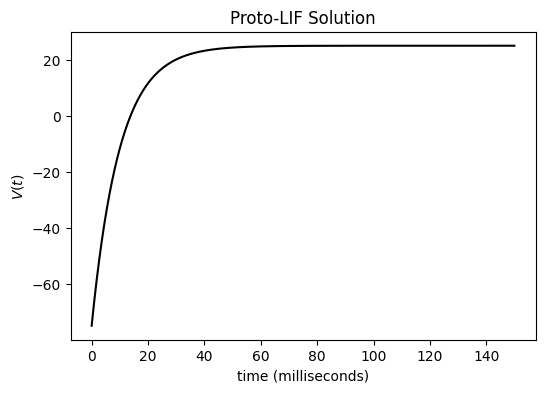

In [8]:
# Choose current magnitude and initialize parameters
I_ext = 1000 #pA
params = default_params()

# Run simulation
proto_LIF_solution, t = simulate_proto_LIF(params, I_ext)

# Plot simulation
fig, ax = plt.subplots(1,1,figsize=(6,4),facecolor='white')
ax.plot(t, proto_LIF_solution, c='black')
ax.set_title(r'Proto-LIF Solution')
ax.set_xlabel('time (milliseconds)')
ax.set_ylabel('$V(t)$')
plt.show()

**Think:** Why does the simulated voltage seem to approach an asymptote and go no further?

**Homework:** Use the proto-LIF differential equation to precisely solve for the steady state voltage that you see in the plot above.

---

### Section 2.3: Build a full LIF model

Based on the work above, our model is not done yet. It is missing the feature where the model hyperpolarizes back toward resting potential, $V_{rest}$. Let's divide both sides by $g_L$ and replace $\frac{C_m}{g_L}$ with $\tau_m$ ($\tau_m = \frac{C_m}{g_L}$). Then, let's add a conditional statement. We thus define the full LIF model as the following:
- $ \tau_m \frac{dV}{dt} = -(V-E_L) + \frac{I_{ext}}{g_L} $
- If $ V(t) = V_{th}$, then $ V(t + dt) = V_{reset} $

The conditional statement means that if $V(t)$ reaches a threshold value $V_{th}$, then at the next time step $V(t)$ will be set to $V_{reset}$. 

This is what makes the core of a functional Leaky Integrate and Fire Model.

Next we will try simulating an LIF model. First, we must define the new form of the differential equation of the LIF model. 

**Code:** Define the `dvdt_LIF()` differential equation used in the LIF model.

In [9]:
def dvdt_LIF(g_L, E_L, tau_m, I_ext, V_val):
    #### TODO ####:
    # Define dvdt with the updated LIF model differential equation
    dvdt = (1/tau_m) * (-(V_val - E_L) + I_ext/g_L) #TODO: Remove in student version
    ##############
    return(dvdt)

Below, we will define `simulate_LIF()` and add other important features to the simulator that makes this model more biologically plausible. This model will thus have the following features:
- Change in voltage based on the voltage of the neuron model and external input current (depolarization)
- Reset voltage when threshold potential is reached (hyperpolarization)
- Spike refractory period $\leftarrow$ (think about why this is included!)

Read the comments within `simulate_LIF()` to understand the input arguments, what steps are involved in the simulation, and the returned outputs of the function. 

(This function has a lot going on! So feel free to only engage with the comments.)

In [10]:
def simulate_LIF(params, I_inj): # Possibly make this into a helper function
    """Compute solution of the LIF model with
    initial condition V_0 for a duration T. Use time step dt for numerical
    solution.

    Args:
    params (dict): parameters for proto-LIF model
    I_inj (scalar): injected external input current

    Returns:
    ndarray, ndarray: `V` for all simulation steps and the time `t` at each step
    """
    
    # Initialize parameters
    g_L = params['g_L']
    E_L = params['E_L']
    V_0 = params['V_0']
    C_m = params['C_m']
    dt  = params['dt']
    T   = params['T']
    V_th = params['V_th']
    V_reset = params['V_reset']
    tau_m = params['tau_m']
    tref = params['tref']
    
    # Initialize variables
    t = np.arange(0, T, dt)
    V = np.zeros_like(t)
    V[0] = V_0 # This is V at time t_0
    I_inj = I_inj * np.ones_like(t)
   
    # Step through system and integrate in time
    rec_spikes = []  # record spike times
    tr = 0.  # the count for refractory duration
    
    for k in range(1, len(t)):
        if tr > 0:  # check if in refractory period
            V[k-1] = V_reset  # set voltage to reset
            tr = tr - 1 # reduce running counter of refractory period

        elif V[k-1] >= V_th:  # if voltage over threshold
            rec_spikes.append(k)  # record spike event
            V[k-1] = V_reset  # reset voltage
            tr = tref / dt  # set refractory time

        # for each point in time, compute dvdt from x[k-1]
        dvdt = dvdt_LIF(g_L, E_L, tau_m, I_inj[k-1], V[k-1])

        # Update x based on x[k-1] and dvdt
        V[k] = V[k-1] + dvdt*dt

    return V, t, rec_spikes

**Visualize:** Let's now initialize our parameters, simulate $V(t)$ over time, and plot the simulation.

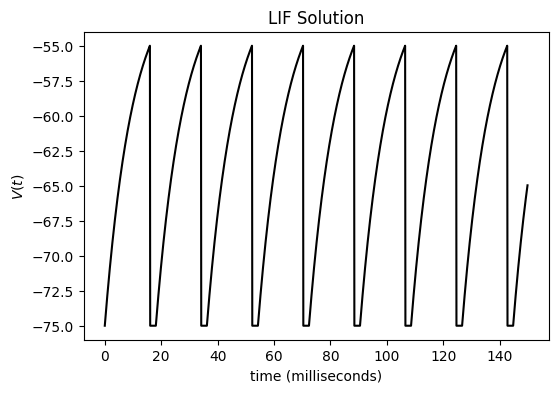

In [11]:
# Choose current magnitude and initialize parameters
I_ext = 250 # pA
params = default_params()

# Run simulation
LIF_solution, t, spike_times = simulate_LIF(params, I_ext)

# Plot simulation
fig, ax = plt.subplots(1,1,figsize=(6,4),facecolor='white')
ax.plot(t, LIF_solution, c='black')
ax.set_title(r'LIF Solution')
ax.set_xlabel('time (milliseconds)')
ax.set_ylabel('$V(t)$')
plt.show()

**Think:** Are the three desired features of the neuron model present in this plot?

**Play:** Try different `I_ext` settings. 
- How does `I_ext` impact the number of spikes in this given amount of time? 
- What feature of the neuron model is directly impacted by increasing or decreasing `I_ext`?

You should notice that the variable `spike_times` is an output of our `simulate_LIF()` function. Let's print them below. 

In [12]:
print(spike_times)

[162, 343, 524, 705, 886, 1067, 1248, 1429]


**Think:** Do the spike times correspond to the "spikes" in the plot above? What must be the units of the spike time output from this simulation? (*Hint:* Use what you know about `dt` and `T`)

## Section 3: Describing an LIF Model's Input/Output Relationship

We now have a working LIF model that let's us explore the following questions mentioned above:
1. Given a current input, how often does a neuron spike?
2. Given a current input, how regularly or irregularly does a neuron spike?

Before we delve into these questions, what do we mean by current input?

### Section 3.1: Current as Gaussian White Noise

The input current we have provided to our LIF neuron thus far has been noiseless and constant. However, input received by a neuron is rarely noiseless - it is noisy and time-varying. Does the amount of noise impact neuron firing properties at all?

This means we can try to answer our two questions above under two conditions: 
- *Given a noisy or noiseless current input*, how often does a neuron spike?
- *Given a noisy or noiseless current input*, how regularly or irregularly does a neuron spike?



---

What do we mean by noisy and noiseless?

**Visualize:** Plot examples of a noisy and a noiseless current.

Let's produce a noisy current input using a gaussian white noise (GWN) signal with mean $\mu$ and and noise $\sigma$. We can visualize this current and provide it as input to our neuron model.

Use the helper function `my_GWN()` to produce a noiseless ('noiseless') current and a noisy current input with mean `mu` and variance `sigma`. Then plot the new current over time to visualize it.

The arguments of `my_GWN()` are `params`, `mu`, `sigma`, and its output is a time-varying current output, and a time array.



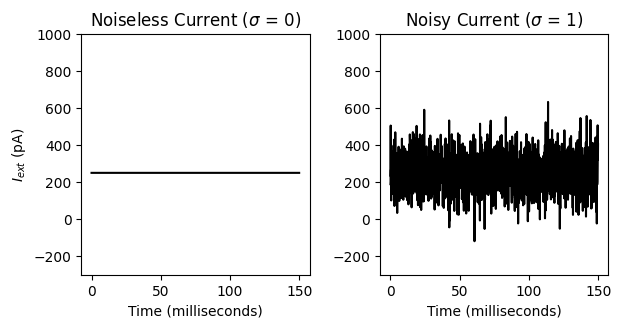

In [13]:
mu = 250 # pA
sigma_noiseless = 0 # standard deviation of a noiseless current
sigma_noisy = 1 # standard deviation of a noisy current
I_ext_noiseless, t = my_GWN(params, mu, sigma_noiseless) 
I_ext_noisy, t = my_GWN(params, mu, sigma_noisy)

fig, ax = plt.subplots(1,2, figsize=(6,3), facecolor='white')
fig.tight_layout(w_pad=2)
y_min, y_max = -300, 1000 # Plotting parameters
ax[0].plot(t, I_ext_noiseless, color='black')
ax[1].plot(t, I_ext_noisy, color='black')
ax[0].set_title(r'Noiseless Current ($\sigma$ = 0)')
ax[1].set_title(r'Noisy Current ($\sigma$ = '+str(sigma_noisy)+')')
ax[0].set_ylim(y_min, y_max)
ax[1].set_ylim(y_min, y_max)
ax[0].set_ylabel(r'$I_{ext}$ (pA)')
ax[0].set_xlabel('Time (milliseconds)')
ax[1].set_xlabel('Time (milliseconds)')
plt.show()

**Visualize:** Give the noisy current as input to an LIF model and observe the voltage trace output.

**Code:** Define the `I_ext` value by using the `my_GWN` function and provide `params`, `mu`, and `sigma` as arguments.

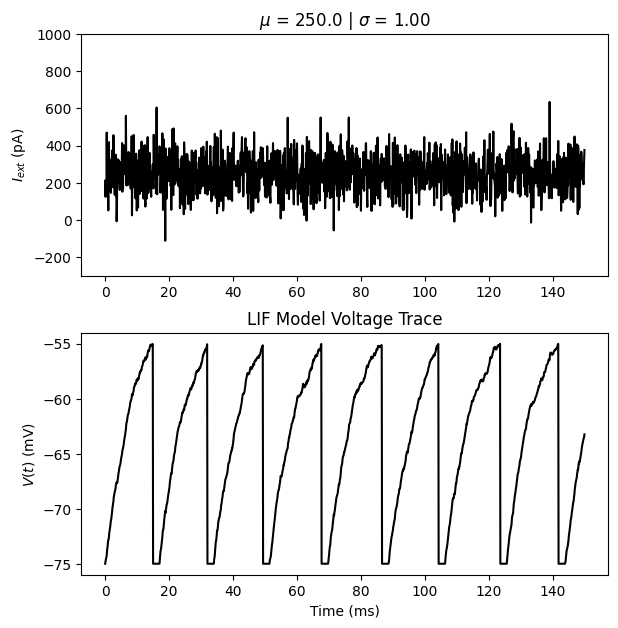

In [14]:
# Simulate a LIF neuron to get spike times

# Choose current magnitude and initialize parameters
params = default_params()
mu = 250
sigma = 1

# Produce Current
#### TODO ####: 
# Use the my_GWN function to produce a noisy time-varying current input array
I_ext, t = my_GWN(params, mu, sigma) # TODO: remove in student version
##############


# Run simulation
solution, t, spike_times = simulate_LIF(params, I_ext)

# Plot the current input and the voltage output
fig, ax = plt.subplots(2,1, figsize=(6,6), facecolor='white')
fig.tight_layout(h_pad=2)
y_min, y_max = -300, 1000 # Plotting parameters
ax[0].plot(t, I_ext, color='black')
ax[1].plot(t, solution, color='black')
ax[0].set_title(r'$\mu$ = %.1f | $\sigma$ = %.2f' % (mu, sigma))
ax[1].set_title('LIF Model Voltage Trace')
ax[0].set_ylim(y_min, y_max)

ax[0].set_ylabel(r'$I_{ext}$ (pA)')
ax[1].set_ylabel(r'$V(t)$ (mV)')
ax[1].set_xlabel('Time (ms)')
plt.show()

**Play:** Change `sigma` to different settings. What do you observe?


Now that we have seen the effects of noiseless and noisy currents, let's begin asking our questions in the sections below

### Section 3.2: Given a current input, how often does a neuron spike?

This is a question of spike frequency. Frequency is the rate at which an event occurs over a unit of time. This can be expressed as: 

$$ Frequency = \frac{\text{"Events"}}{\text{"Time"}} $$

An example of this is beats per minute in heart rate (or music!). ($f = \frac{\text{# of beats}}{\text{1 minute}}$)

In the case of neuron modeling, we are interested in spikes per second. ($f = \frac{\text{# of spikes}}{\text{1 second}}$)

Number of events per second can be expressed as a unit Hertz: $Hz = \frac{\text{# of events}}{\text{1 second}}$

Therefore, if 5 spikes occur in 1 second, then the frequency of spiking is 5 Hz.

Let's calculate a spike rate given some assumed noiseless input current, $I_{ext}$. First let's simulate an LIF model with a given input current of 250 pA.

In [15]:
# Choose current magnitude and initialize parameters
mu = 250 #pA
sigma = 0
params = default_params()
I_ext, t = my_GWN(params, mu, sigma)

# Run simulation
solution, t, spike_times = simulate_LIF(params, I_ext)

The output of the simulation function is the voltage trace, the time range split into time steps, and an array of spike times.

To calculate frequency, we are interested in using the number of spikes over a given range of time in units of spikes per second. To do this, we will need the `spike_times` array.

**Code:** Complete the `spike_freq()` function.

In [16]:
# Calculate spike frequency
def spike_freq(spike_times, params):
    # Initialize simulation time
    T = params['T']
    T = T * (1 / 1000) # 1 second per 1000 milliseconds
    
    # Count number of spikes within simulation time
    num_spikes = len(spike_times)
    
    #### TODO ####: 
    # Calculate spike frequency
    freq = num_spikes / T ##TODO: Remove in student version
    ##############
    
    return freq

Now that we've defined the spike frequency function, let's use it to calculate the number of spikes per second in Hz.

In [17]:
freq = spike_freq(spike_times, params)
print('Frequency = %.2f Hz' % freq)

Frequency = 53.33 Hz


**Homework:** Is there a current $I_{ext}$ where the frequency should be zero? 
- How does this current relate to the steady state of the first equation in the LIF model?
- How does this steady state relate to $V_{th}$?

Now that we have the spike frequency function, we could play with the $I_{ext}$ input one at a time and see what frequencies result, but let's go a step further.

---

#### Section 3.2.1: Generate an F-I Curve

We may have observed in previous exercises that the "spikes" generated by the LIF model get more numerous and more frequent as we try higher current input magnitudes. But how do we clearly visualize the impact of current input on spike frequency?

We can visualize this by producing an **F-I Curve**. This is a plot of frequencies as a result of a range of currents. F-I Curves are useful for visualizing the input-output relationship of our model neuron. 

Below we define the `FI_curve` function that generates the data we plot to produce an F-I curve. Read the comments to see what steps are taken in the function.

In [18]:
def FI_curve(params, I_max=1000, I_step=50, sigma=0):
    
    # Initialize current ranges
    I_range = np.arange(0, I_max, I_step)

    # Define for loop over different current values
    freq_rec = [] # Record frequency from each simulation

    for I_ext in I_range:
        # Produce time-varying current input
        mu = I_ext
        I_ext, t = my_GWN(params, mu, sigma)
        
        # Run simulation
        solution, t, spike_times = simulate_LIF(params, I_ext)

        # Calculate frequency
        freq = spike_freq(spike_times, params)

        # Record frequency
        freq_rec.append(freq)
    
    return I_range, freq_rec

**Visualize:** Produce an F-I Curve using the `FI_curve()` function.

In [19]:
# Initialize parameters
params = default_params()
params['tau_m'] = 10.0

I_max = 1000 # Maximum I_ext value in I_ext range
I_step = 10 # Size of step in I_ext range

I_ext_range, frequencies = FI_curve(params, I_max, I_step)

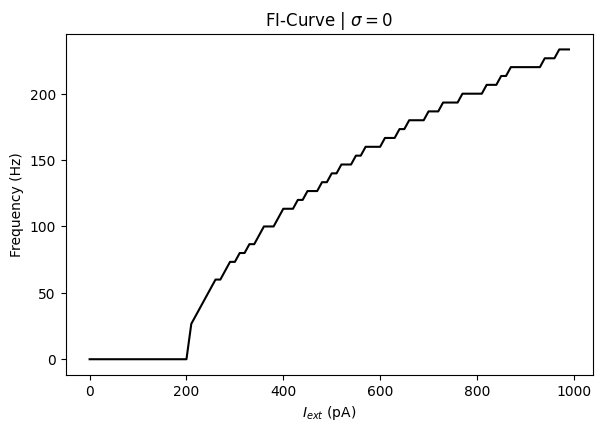

In [20]:
# Plot the F-I Curve
fig, ax = plt.subplots(1,1, figsize=(6,4), facecolor='white')
fig.tight_layout()
# y_min, y_max = -300, 1000 # Plotting parameters
ax.plot(I_ext_range, frequencies, color='black')
ax.set_title(r'FI-Curve | $\sigma=0$')

ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel(r'$I_{ext}$ (pA)')
plt.show()

**Play:** What happens if you increase the maximum range of the current, `I_max`, to be much larger? Why might you see this particular feature at higher values of $I_{ext}$?

**Play:** Try different values for the `tau_m` parameter of the LIF model. See above, change the value in the line: `params['tau_m'] = 10.0`). How does this value impact the F-I curve? 

(*Hint:* Pay attention to the y-axis)

---

A notable feature of this neuron is the current at which the neuron begins spiking, which is called the **Rheobase**. It can be observed in an F-I curve fairly easily. 

**Think:** What is the rheobase for this LIF neuron?

**Homework:** Plot and compare the F-I curves of neuron models with different settings of `tau_m`. 
- How does `tau_m` impact the rheobase of the neuron?

---

#### Section 3.2.2: How does input noise impact the F-I curve of a LIF model?

So far you've investigated how the magnitude of a noiseless current impacts the spiking frequency of an LIF model. This leaves another investigation: *"How does the variability of noisy current impact the spiking frequency of a neuron?"*

**Visualize:** Plot an F-I curve with input noise included.

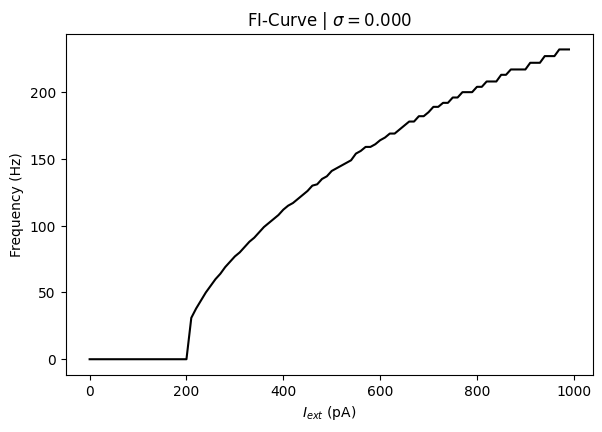

In [21]:
# Initialize parameters
params = default_params()
params['T'] = 1000 # 1 second of simulation time

I_max = 1000
I_step = 10

sigma = 0 # Change sigma value and plot the results below!

# Generate F-I curve values
I_ext_range, frequencies = FI_curve(params, I_max, I_step, sigma)

# Plot the F-I Curve
fig, ax = plt.subplots(1,1, figsize=(6,4), facecolor='white')
fig.tight_layout()
ax.plot(I_ext_range, frequencies, color='black')
ax.set_title(r'FI-Curve | $\sigma=%.3f$' % sigma)
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel(r'$I_{ext}$ (pA)')
plt.show()

**Play:** Use the `FI_curve` function to explore how different `sigma` settings for the GWN input impacts the F-I curve. 
- What happens to the rheobase?
- How would you describe the shape of the F-I curve with and without noise?
- Set `I_max = 5000`, and look at the shape of the F-I curve with and without noise. What changes and what stays the same? Is this relevant to biology?

**Think:** Answer this section's question: *Given a current input, how often does a neuron spike?*

---

### Section 3.2: Given a current input, how regularly or irregularly does a neuron spike?

In the previous section, we quantified how often a neuron spikes as a measure of spike frequency and visualized how the external current $I_{ext}$ impacts this quantity. 

In this section we will explore the question of spike regularity. How can we quantify this?

To begin, we can see that a notable observable feature of a voltage trace is the inter-spike interval (ISI). This is the difference between one spike and the next.

<div>
<img src="./images/3_ISI.svg" width="400"/>
</div>

Spike regularity relates to the distribution of ISI between all spikes in a voltage trace.

Let's consider 2 possibilities for regularity. 
- IF all of the ISIs would be the same, the neuron would be completely regular (clock-like)
- If all of the ISIs were random, the neuron would be irregular to some degree

If we plotted these possibilities as histograms, the histograms may look like the cartoon below:

<div>
<img src="./images/4_ISI_hist.png" width="600">
</div>

**Think:** Predict what this histogram would look like if the ISIs were completely irregular.

To investigate spike regularity we can do these 3 things, which we'll explore in the following sections:
1. Measure all ISIs in a voltage trace
2. Visualize the ISIs in a histogram
3. Calculate a measure of regularity

---

#### Section 3.2.1: Measure Inter-Spike Interval and Visualize Histogram

First, let's get spike times from a LIF simulation.

In [22]:
# Simulate a LIF neuron to get spike times

# Choose current magnitude and initialize parameters
I_ext = 250 #pA
params = default_params()
# params['T'] = 50.0


# Run simulation
solution, t, spike_times = simulate_LIF(params, I_ext)

In [23]:
print('Spike Times:\n',spike_times)
print('# of Spikes: ', len(spike_times))

Spike Times:
 [162, 343, 524, 705, 886, 1067, 1248, 1429]
# of Spikes:  8


Let's calculate ISI. It can be summarized in the following equation

$ISI = \text{spiketime}_p - \text{spiketime}_{p-1}$

Note that the units of `spike_times` array is a function of $dt$. This may not be in units of milliseconds! If `dt = 0.1`, then a spike time of 100 is actually: 

$$ \text{spike_time} * dt = 100 * 0.1 \text{ms} = 10.0 \text{ms}$$

Therefore, we need to convert `spike_times` to milliseconds, and then calculate the difference in spike times.

**Code:** Calculate the difference in spike times between all pairs of spikes using the `np.diff()` function.

(*Hint:* use the `help(np.diff)` to view the documentation for `np.diff()`.)

In [24]:
# Calculate an array of ISIs from the array of spike_times

spike_times_ms = np.array(spike_times) * params['dt']

# Use the np.diff function to find the ISIs of spike_times_ms

#### TODO ####:
# Calculate ISIs using the np.diff function
ISI_array = np.diff(spike_times_ms) # TODO: Remove in student version
##############

print('Calculated ISIs:', ISI_array)

Calculated ISIs: [18.1 18.1 18.1 18.1 18.1 18.1 18.1]


Now let's make a histogram of our ISIs. We can do so using the `plt.hist()` function

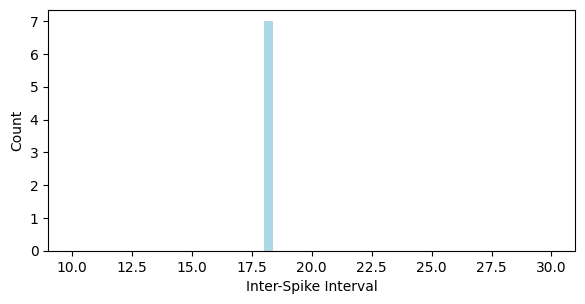

In [25]:

# Initialize histogram visualization settings
bins = 50 # Number of bins the ISI_range is split up into
ISI_range = (10, 30) # Range of ISIs included

# Plot histogram
fig, ax = plt.subplots(1,1,figsize=(6,3),facecolor='white')
fig.tight_layout()
ax.hist(ISI_array, range=ISI_range, bins=bins, color='lightblue')
ax.set_xlabel('Inter-Spike Interval')
ax.set_ylabel('Count')
plt.show()

**Think:** How regular is this LIF neuron output? Does this change when we try different $I_{ext}$ current magnitudes?

---

#### Section 3.2.2: Visualize the impact of noise on Inter-Spike Intervals

How might input current noise have an impact on regularity? Let's visualize this using a histogram.

Below we will
1. Run a LIF simulation 
    a. with a non-noisy current
    b. with a noisy current
2. Calculate ISI's for both sets of spike times
3. Plot both in histograms for comparison

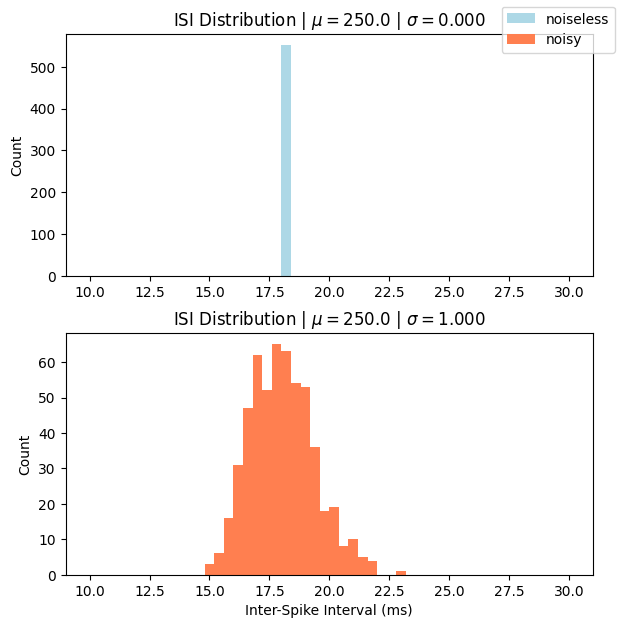

In [26]:
# Run LIF simulations for noisy and non-noisy currents

# Initialize parameters
params = default_params()
params['T'] = 10000

# Choose current input settings
I_ext = 250 # pA

mu = I_ext
sigma_noiseless = 0
sigma_noisy = 1

# Initialize Current Input
I_ext_noiseless, t = my_GWN(params, mu, sigma_noiseless)
I_ext_noisy, t = my_GWN(params, mu, sigma_noisy)


### Run simulations ###

# Non-noisy current simulation
solution_noiseless, t, spike_times_noiseless = simulate_LIF(params, I_ext_noiseless)

# Noisy current simulation
solution_noisy, t, spike_times_noisy = simulate_LIF(params, I_ext_noisy)

# Convert spike times to milliseconds
spike_times_noiseless_ms = np.array(spike_times_noiseless) * params['dt']
spike_times_noisy_ms = np.array(spike_times_noisy) * params['dt']

## Calculate ISIs
ISI_noiseless = np.diff(spike_times_noiseless_ms)
ISI_noisy = np.diff(spike_times_noisy_ms)


### Plot Histograms ###

# Initialize histogram plotting parameters
bins = 50
ISI_range = (10, 30)

# Plot histogram
fig, ax = plt.subplots(2,1, figsize=(6,6), facecolor='white')
fig.tight_layout(h_pad=2)
ax[0].hist(ISI_noiseless, bins=bins, range=ISI_range, label='noiseless', color='lightblue')
ax[1].hist(ISI_noisy, bins=bins, range=ISI_range, label='noisy', color='coral')
ax[1].set_xlabel('Inter-Spike Interval (ms)')
ax[0].set_ylabel('Count')
ax[1].set_ylabel('Count')
ax[0].set_title(r'ISI Distribution | $\mu=%.1f$ | $\sigma=%.3f$' % (mu, sigma_noiseless))
ax[1].set_title(r'ISI Distribution | $\mu=%.1f$ | $\sigma=%.3f$' % (mu, sigma_noisy))
fig.legend()
plt.show()


**Play**: Change $\sigma$ and observe what happens to the ISIs.

---

#### Section 3.2.3: Quantify regularity with coefficient of variance

We've visualized when LIF model voltage output yields some degree of irregular spike times. But how do we quantify this irregularity?

For this, we use the **Coefficient of variance of inter-spike interval**, or $CV_{ISI}$, which has the following equation:

$$ CV_{ISI} = \frac{std_{ISI}}{mean_{ISI}} $$

where $std_{ISI}$ and $mean_{ISI}$ are the standard deviation and mean of the set of ISIs of the neuron's voltage output.

**Think:** This is a ratio that is between 0 and 1. Sketch or discuss the shape of the histogram of ISI's that would correspond to when $CV_{ISI} = 0$ and when $CV_{ISI} = 1$. (*Hint:* What values of $CV_{ISI}$ would correspond to complete regularity and complete irregularity?)

Below, let's define a function `get_CV()` that will quantify the $CV_{ISI}$, given a set of spike times. Use `np.mean()` and `np.std()` to find the mean and standard deviation of the ISIs within the function. Then use these values to calculate $CV_{ISI}$ Use the `help()` function to see the documentation of these functions to figure out the input arguments.

In [27]:
# Define function to calculate coefficient of variance of ISI 

def get_CV(spike_times_array):
    isi_array = np.diff(spike_times_array) # Calculate ISIs
    
    #### TODO ####:
    # Use np.mean and np.std to find mean and standard deviation
    mean_isi = np.mean(isi_array) # Remove in student version
    std_isi = np.std(isi_array)
    # Calculate CV
    cv = std_isi / mean_isi
    ##############
    return cv

Now let's put it all together. Using the code below, change the `sigma` and `mu` parameters for the noisy input and view how it impacts CV and the ISI histogram. We'll also print the minimum, maximum, mean, and standard deviation of each ISI histogram. The plotting function will display the calculated $CV_{ISI}$ for each simulation.

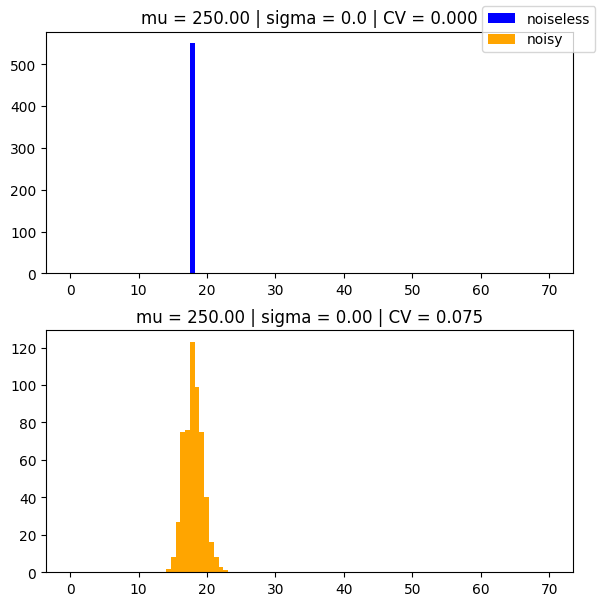

ISI_noiseless Statistics
Min: 18.1 | Max: 18.1
Mean: 18.1 | Std: 0.0


ISI_noisy Statistics
Min: 14.3 | Max: 22.7
Mean: 18.0 | Std: 1.3


In [28]:
# Run LIF simulations for noisy and non-noisy currents

# Choose current input settings
mu = 250 # pA
sigma_noiseless = 0
sigma_noisy = 1

# Plotting parameters
hist_minimum = 0
hist_maximum = 70
hist_bins = 100

# Initialize parameters
params = default_params()
params['T'] = 10000 # Setting this to 10 seconds to get more recorded spikes

# Initialize input currents
I_ext_noiseless, t = my_GWN(params, mu, sigma_noiseless)
I_ext_noisy, t = my_GWN(params, mu, sigma_noisy)


### Run LIF simulations ###

# Non-noisy current simulation
solution_noiseless, t, spike_times_noiseless = simulate_LIF(params, I_ext_noiseless)

# Noisy current simulation
solution_noisy, t, spike_times_noisy = simulate_LIF(params, I_ext_noisy)

# Convert spike times to milliseconds
spike_times_noiseless_ms = np.array(spike_times_noiseless) * params['dt'] # convert to milliseconds
spike_times_noisy_ms = np.array(spike_times_noisy) * params['dt'] # convert to milliseconds

# Calculate ISIs
ISI_noiseless = np.diff(spike_times_noiseless_ms)
ISI_noisy = np.diff(spike_times_noisy_ms)

# Calculate CVs
CV_noiseless = get_CV(spike_times_noiseless_ms)
CV_noisy = get_CV(spike_times_noisy_ms)


### Plot Histograms with info in titles of graphs: ###

# Histogram plotting parameters
ISI_range = (hist_minimum, hist_maximum)

# Plot histograms
fig, ax = plt.subplots(2,1, figsize=(6,6), facecolor='white')
fig.tight_layout(h_pad=2)
ax[0].hist(ISI_noiseless, bins=hist_bins, range=ISI_range, label='noiseless', color='blue')
ax[1].hist(ISI_noisy, bins=hist_bins, range=ISI_range, label='noisy', color='orange')

# Display simulation info and CV
ax[0].set_title(('mu = %.2f | sigma = 0.0 | CV = %.3f' % (I_ext, CV_noiseless)))
ax[1].set_title(('mu = %.2f | sigma = %.2f | CV = %.3f' % (mu, sigma, CV_noisy)))
fig.legend()
plt.show()

# Print statistics
print('ISI_noiseless Statistics')
print('Min: %.1f | Max: %.1f' % (np.min(ISI_noiseless), np.max(ISI_noiseless)))
print('Mean: %.1f | Std: %.1f' % (np.mean(ISI_noiseless), np.std(ISI_noiseless)))
print('\n')


print('ISI_noisy Statistics')
print('Min: %.1f | Max: %.1f' % (np.min(ISI_noisy), np.max(ISI_noisy)))
print('Mean: %.1f | Std: %.1f' % (np.mean(ISI_noisy), np.std(ISI_noisy)))

**Play:** Try different noisy input current settings for `mu` and `sigma_noisy`. How does increasing or decreasing these input parameter values change shape of the ISI histogram?

**Think:** Set `mu=250`, `sigma_noisy=25`, and `hist_bins=100`. 
- What is the shape of the resulting histogram for the noisy input? 
- What kind of function would best fit the resulting histogram for the noisy input?


**Think:** Answer this section's question: *"Given a current input, how regularly or irregularly does a neuron spike?"*


---

## Conclusion

In this tutorial you have:
1. Built a simplified biophysical model of a neuron, the leaky-integrate and fire model. 
2. Investigated how this model relates different kinds of current input to different kinds of output. 
3. Quantified how frequently and regularly this model fires action potentials as a function of its current input.

Use this tutorial and your notes to think about how you might build on the LIF model or develop other models in order to answer your questions. When you are in the process of building a model, deliberately consider what empirical properties you wish to include or exclude. Once you have a neuron model, think about how it transforms its input to output, and how to represent or quantify this relationship to either answer your questions or explore how your model impacts this relationship. Lastly, are there modifiable properties of your model that allow it to best reproduce the input-output relationships you see in data from real neurons? How would you validate this LIF model?

<div>
<img src="./images/5_Overview.png" width="600">
</div>

Mini-projects draft:
1. When given an external current *in vitro*, a recorded voltage trace of a neuron can exhibit a feature called "adaptation". Use a "Generalized" LIF model to reproduce this feature, then use our I/O analysis methods to see how GLIF and LIF differ (frequency, regularity)
2. Simulate the HH model. Use our I/O analysis methods on the model to characterize it. What happens if you remove $I_{Na}$? Remove $I_K$? Remove $I_{leak}$?

Projects draft:
1. Compare a LIF model to a HH model (make the HH model). This requires fitting the LIF model to the HH model. Use resources for model fitting.